<a href="https://colab.research.google.com/github/qoyyimil/pba/blob/main/notebooks/4_TFIDF_Moovit_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-IDF & Model Klasifikasi Sentimen
Notebook ini bertujuan untuk membangun dan mengevaluasi beberapa model machine learning untuk klasifikasi sentimen pada ulasan aplikasi Moovit menggunakan representasi TF-IDF.

In [1]:
# --- Instalasi Library ---
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

# --- Import Library ---
import pandas as pd
import numpy as np
import re

# -- Library untuk Visualisasi --
import seaborn as sns
import matplotlib.pyplot as plt

# -- Library untuk TF-IDF & Machine Learning --
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# --- Konfigurasi Tampilan ---
pd.set_option("display.max_colwidth", 200)
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style("whitegrid")

In [2]:
# Load dataset yang sudah bersih
try:
    df = pd.read_csv('moovit_reviews_cleaned.csv')
except FileNotFoundError:
    print("File 'moovit_reviews_cleaned.csv' tidak ditemukan.")
else:
    # Menangani nilai NaN di final_content jika ada
    df.dropna(subset=['final_content'], inplace=True)

    # --- Membuat Label Sentimen Biner ---
    # Kita akan mengklasifikasikan skor 4 & 5 sebagai 'positif' (1)
    # dan skor 1 & 2 sebagai 'negatif' (0).
    # Skor 3 (netral) akan kita abaikan untuk menyederhanakan masalah.
    df['sentiment'] = df['score'].apply(lambda x: 1 if x > 3 else (0 if x < 3 else -1))
    df_model = df[df['sentiment'] != -1].copy() # Buat DataFrame baru tanpa ulasan netral

    print("Dataset bersih berhasil dimuat.")
    print(f"Jumlah data setelah membuang ulasan netral: {len(df_model)} baris.")
    print("\nDistribusi Sentimen:")
    print(df_model['sentiment'].value_counts())
    df_model.head()

Dataset bersih berhasil dimuat.
Jumlah data setelah membuang ulasan netral: 1982 baris.

Distribusi Sentimen:
sentiment
1    1203
0     779
Name: count, dtype: int64


In [3]:
# Tentukan variabel X (fitur) dan y (target/label)
X = df_model['final_content']
y = df_model['sentiment']

# Bagi data menjadi 80% data latih dan 20% data uji
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42, # random_state agar hasil pembagian data selalu sama
    stratify=y # stratify agar proporsi sentimen di data latih dan uji sama
)

print("Ukuran data latih:", X_train.shape[0])
print("Ukuran data uji:", X_test.shape[0])

Ukuran data latih: 1585
Ukuran data uji: 397


In [11]:
# Inisialisasi TfidfVectorizer dengan min_df, max_df, dan n-gram
tfidf = TfidfVectorizer(
    min_df=5,           # Abaikan kata yang muncul di < 5 ulasan (membuang typo)
    max_df=0.8,         # Abaikan kata yang muncul di > 80% ulasan (membuang stopwords)
    ngram_range=(1, 2)  # Melihat kata tunggal DAN pasangan kata (mis: "tidak akurat")
)

# Terapkan TF-IDF hanya pada data latih (X_train)
X_train_tfidf = tfidf.fit_transform(X_train)

# Terapkan transformasi yang sama pada data uji (X_test)
X_test_tfidf = tfidf.transform(X_test)

print("Bentuk matriks TF-IDF untuk data latih (baru):", X_train_tfidf.shape)
print("Bentuk matriks TF-IDF untuk data uji (baru):", X_test_tfidf.shape)

Bentuk matriks TF-IDF untuk data latih (baru): (1585, 270)
Bentuk matriks TF-IDF untuk data uji (baru): (397, 270)


## Tahap Pelatihan & Evaluasi Model
Sekarang data kita sudah dalam bentuk numerik (TF-IDF), kita akan melatih tiga model klasifikasi yang populer untuk tugas analisis sentimen:
1.  **Logistic Regression**: Model yang baik sebagai *baseline*, cepat, dan mudah diinterpretasikan.
2.  **Multinomial Naive Bayes**: Model probabilistik yang sangat efektif untuk klasifikasi teks.
3.  **Linear Support Vector Machine (LinearSVC)**: Seringkali menjadi salah satu model dengan performa terbaik untuk data teks.

Kita akan mengevaluasi setiap model berdasarkan akurasinya pada data uji.

In [12]:
# Inisialisasi model Logistic Regression
log_reg = LogisticRegression(random_state=42)

print("--- Melatih Model Logistic Regression ---")
# Latih model menggunakan data TF-IDF
log_reg.fit(X_train_tfidf, y_train)

# Lakukan prediksi pada data uji
y_pred_log_reg = log_reg.predict(X_test_tfidf)

# Evaluasi performa model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"\nAkurasi Logistic Regression: {accuracy_log_reg:.4f}")

print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred_log_reg, target_names=['Negatif', 'Positif']))

--- Melatih Model Logistic Regression ---

Akurasi Logistic Regression: 0.8111

Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.78      0.72      0.75       156
     Positif       0.83      0.87      0.85       241

    accuracy                           0.81       397
   macro avg       0.80      0.79      0.80       397
weighted avg       0.81      0.81      0.81       397



In [13]:
# Inisialisasi model Multinomial Naive Bayes
naive_bayes = MultinomialNB()

print("--- Melatih Model Multinomial Naive Bayes ---")
# Latih model
naive_bayes.fit(X_train_tfidf, y_train)

# Lakukan prediksi
y_pred_nb = naive_bayes.predict(X_test_tfidf)

# Evaluasi performa
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"\nAkurasi Multinomial Naive Bayes: {accuracy_nb:.4f}")

print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred_nb, target_names=['Negatif', 'Positif']))

--- Melatih Model Multinomial Naive Bayes ---

Akurasi Multinomial Naive Bayes: 0.8161

Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.79      0.72      0.76       156
     Positif       0.83      0.88      0.85       241

    accuracy                           0.82       397
   macro avg       0.81      0.80      0.80       397
weighted avg       0.81      0.82      0.81       397



In [14]:
# Inisialisasi model LinearSVC
linear_svc = LinearSVC(random_state=42)

print("--- Melatih Model Linear Support Vector Machine (SVC) ---")
# Latih model
linear_svc.fit(X_train_tfidf, y_train)

# Lakukan prediksi
y_pred_svc = linear_svc.predict(X_test_tfidf)

# Evaluasi performa
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"\nAkurasi Linear SVC: {accuracy_svc:.4f}")

print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred_svc, target_names=['Negatif', 'Positif']))

--- Melatih Model Linear Support Vector Machine (SVC) ---

Akurasi Linear SVC: 0.8186

Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.79      0.74      0.76       156
     Positif       0.84      0.87      0.85       241

    accuracy                           0.82       397
   macro avg       0.81      0.80      0.81       397
weighted avg       0.82      0.82      0.82       397



## Perbandingan Performa Model
Terakhir, kita bandingkan akurasi dari ketiga model untuk menentukan mana yang terbaik untuk dataset kita.

--- Perbandingan Akurasi Model ---
                 Model   Akurasi
2           Linear SVC  0.818640
1          Naive Bayes  0.816121
0  Logistic Regression  0.811083


/tmp/ipython-input-3632400925.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_comparison, x='Akurasi', y='Model', palette='rocket')


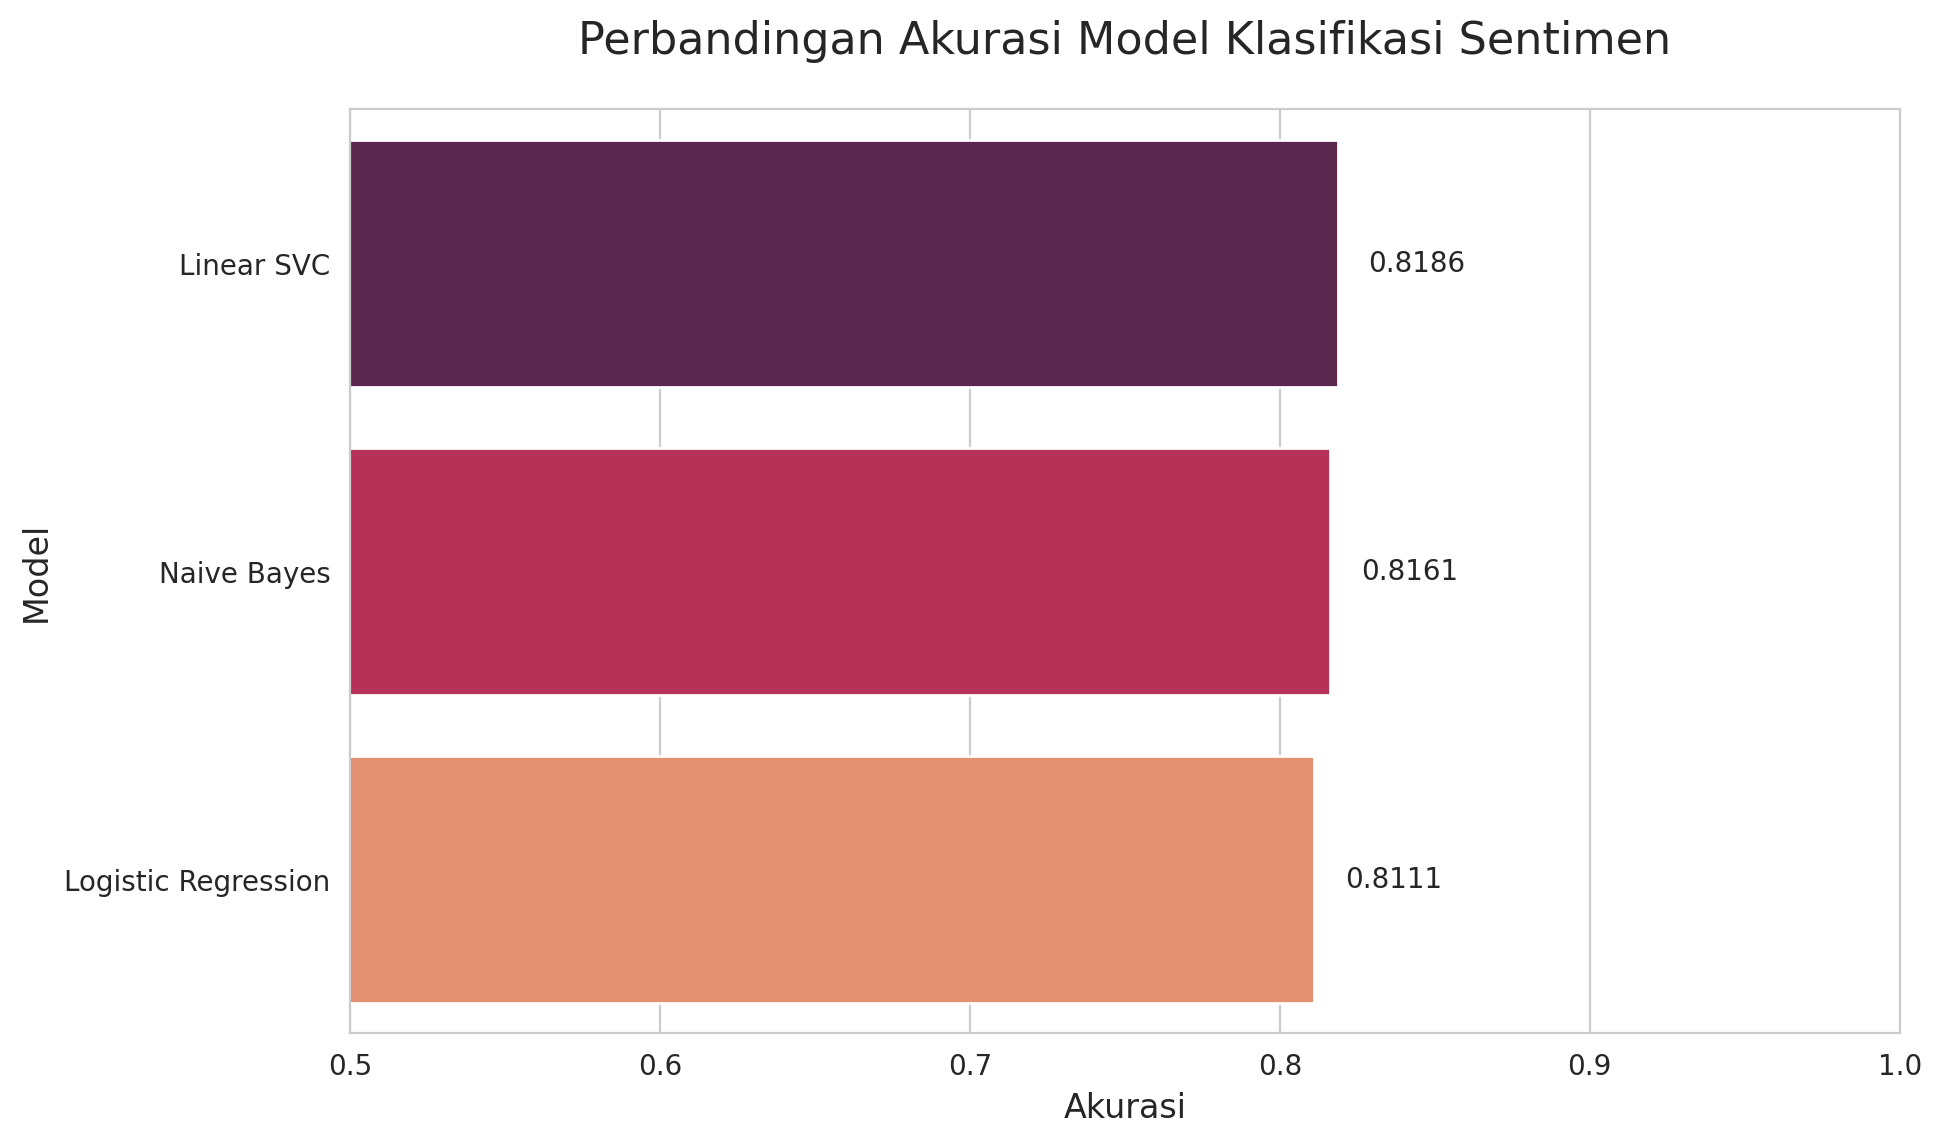

In [15]:
# Buat DataFrame untuk perbandingan
model_accuracies = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'Linear SVC'],
    'Akurasi': [accuracy_log_reg, accuracy_nb, accuracy_svc]
}
df_comparison = pd.DataFrame(model_accuracies).sort_values(by='Akurasi', ascending=False)

print("--- Perbandingan Akurasi Model ---")
print(df_comparison)

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(data=df_comparison, x='Akurasi', y='Model', palette='rocket')
plt.title('Perbandingan Akurasi Model Klasifikasi Sentimen', fontsize=16, pad=20)
plt.xlabel('Akurasi', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0.5, 1.0) # Set limit sumbu x agar lebih mudah dibaca

# Menambahkan label pada bar
for index, value in enumerate(df_comparison['Akurasi']):
    plt.text(value + 0.01, index, f'{value:.4f}', va='center')

plt.show()

## Menjalankan Skrip TF-IDF Eksternal
Di bagian ini, kita akan menjalankan skrip `TFIDF.py` dari repositori GitHub yang diberikan untuk menghitung skor TF-IDF pada dataset kita. Ini adalah latihan untuk memahami implementasi TF-IDF dari dasar.

Langkah-langkahnya adalah:
1.  Mengunduh skrip `TFIDF.py` dari GitHub.
2.  Mempersiapkan data kita: mengubah kolom `final_content` dari file CSV menjadi sebuah file teks (`.txt`), karena skrip tersebut membaca file teks.
3.  Menjalankan skrip tersebut menggunakan data teks kita.

In [16]:
import pandas as pd
import numpy as np
from collections import Counter
from numpy.linalg import norm
import nltk
nltk.download('stopwords')


class ManualTFIDF:
    def __init__(self, corpus_list):
        """
        Inisialisasi dengan sebuah list of strings (dokumen yang sudah bersih).
        Contoh: df['final_content'].tolist()
        """
        self.corpus = corpus_list
        self.vocabulary = list(set(word for doc in self.corpus for word in doc.split()))

    def calculate_tf(self):
        """Menghitung Term Frequency (TF)"""
        tf_data = []
        for doc in self.corpus:
            doc_counts = Counter(doc.split())
            # Hanya hitung kata yang ada di vocabulary
            tf_doc = {word: doc_counts.get(word, 0) for word in self.vocabulary}
            tf_data.append(tf_doc)
        return pd.DataFrame(tf_data)

    def calculate_idf(self, tf_df):
        """Menghitung Inverse Document Frequency (IDF)"""
        num_documents = len(self.corpus)
        # Hitung di berapa dokumen setiap kata muncul
        df = (tf_df > 0).sum(axis=0)
        # Rumus IDF
        idf = np.log((num_documents + 1) / (df + 1)) + 1
        return idf

    def fit_transform(self):
        """Menghitung dan mengembalikan matriks TF-IDF"""
        tf_df = self.calculate_tf()
        idf_vector = self.calculate_idf(tf_df)

        # Perkalian TF dengan IDF
        tfidf_matrix = tf_df.multiply(idf_vector, axis=1)

        # Normalisasi L2 (opsional, tapi praktik yang baik)
        norms = norm(tfidf_matrix, axis=1)
        # Hindari pembagian dengan nol
        norms[norms == 0] = 1

        normalized_tfidf = tfidf_matrix.div(norms, axis=0)

        return normalized_tfidf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Siapkan data input (sebuah list dari semua ulasan bersih)
corpus_list = df_model['final_content'].tolist()

# Inisialisasi dan jalankan class ManualTFIDF
manual_tfidf_calculator = ManualTFIDF(corpus_list)
tfidf_result_df = manual_tfidf_calculator.fit_transform()

print("--- Hasil Matriks TF-IDF (Manual) ---")
print("Bentuk Matriks:", tfidf_result_df.shape)
print("\n--- Contoh Hasil (5 baris pertama, 10 kolom dengan skor tertinggi) ---")

# Menampilkan 10 kata dengan skor IDF tertinggi (kata paling informatif)
top_idf_words = tfidf_result_df.sum().nlargest(10).index
print(tfidf_result_df.head()[top_idf_words])

# Menampilkan skor TF-IDF untuk kata-kata kunci
print("\n--- Skor TF-IDF untuk beberapa kata kunci ---")
keywords = ['iklan', 'rute', 'jadwal', 'bayar', 'mudah', 'akurat']
# Filter kolom yang ada di DataFrame
existing_keywords = [k for k in keywords if k in tfidf_result_df.columns]
print(tfidf_result_df[existing_keywords].head())

--- Hasil Matriks TF-IDF (Manual) ---
Bentuk Matriks: (1982, 956)

--- Contoh Hasil (5 baris pertama, 10 kolom dengan skor tertinggi) ---
   oke     iklan  mantap    akurat  jalan  jadwal      rute  mudah    sesuai  \
0  0.0  0.000000     0.0  1.000000    0.0     0.0  0.000000    0.0  0.000000   
1  0.0  0.260682     0.0  0.000000    0.0     0.0  0.000000    0.0  0.331516   
2  0.0  0.000000     0.0  0.727497    0.0     0.0  0.686111    0.0  0.000000   
3  0.0  0.000000     0.0  0.000000    0.0     0.0  0.000000    0.0  0.000000   
4  0.0  0.297530     0.0  0.000000    0.0     0.0  0.000000    0.0  0.000000   

   bus  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  

--- Skor TF-IDF untuk beberapa kata kunci ---
      iklan      rute  jadwal  bayar  mudah    akurat
0  0.000000  0.000000     0.0    0.0    0.0  1.000000
1  0.260682  0.000000     0.0    0.0    0.0  0.000000
2  0.000000  0.686111     0.0    0.0    0.0  0.727497
3  0.000000  0.000000     0.0    0.0    0.0  0.000000
4  0.29753